In [1]:
# %% [markdown]
# # 🥋 Training the Universal Log-Return Predictor
# This notebook trains an LSTM to predict **Daily Log-Returns** (percentage moves).
# 
# **Version:** Mini-Batch Training (Fixes Flatline) + Simplified Model (1 Layer).

# %%

In [2]:
import sys
import os
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader  # <--- Batch Training
from tqdm import tqdm

# 1. Setup Paths
sys.path.append(os.path.abspath(os.path.join('..')))

# Import Custom Modules
from src.data_utils import fetch_crypto_data, add_technical_indicators, create_sequences
from src.model_defs import CryptoLSTM

# Seeds
torch.manual_seed(42)
np.random.seed(42)

print("✅ Libraries & Modules Loaded.")


✅ Libraries & Modules Loaded.


In [3]:
# %% [markdown]
# ### 2. Data Loading & Feature Engineering

# %%
# Fetch Data (Bitcoin as the training base)
raw_df = fetch_crypto_data(ticker="BTC-USD", period="5y", interval="1d")

# Add Indicators
df, close_prices = add_technical_indicators(raw_df)

print(f"Data Shape: {df.shape}")
display(df.tail())


📥 Fetching BTC-USD data (5y, 1d)...


c:\Users\ykibarog\Desktop\project\xai-crypto-trader\src\data_utils.py:12: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, period=period, interval=interval, progress=False)


✅ Loaded 1827 rows.
Data Shape: (1794, 7)


,Log_Ret,Log_Vol,RSI,MACD,MACD_Signal,BB_Upper,BB_Lower
Date,,,,,,,
2025-11-21,-0.017950,25.584298,23.455865,-5593.088487,-4333.187186,112670.551426,85034.953261
2025-11-22,-0.005212,24.431779,23.086270,-5914.825686,-4649.514886,111590.598351,83515.779774
2025-11-23,0.025159,24.785146,28.963539,-5927.453238,-4905.102556,110716.526066,82415.600496
2025-11-24,0.016742,25.033177,32.725624,-5752.886949,-5074.659435,110306.336904,81493.793564
2025-11-25,-0.010564,24.896387,31.585496,-5624.550868,-5184.637722,109447.160752,80698.087685


In [4]:
# %% [markdown]
# ### 3. Preprocessing & Scaling

# %%
data_values = df.values

# Scale (StandardScaler is crucial for log-returns)
scaler = StandardScaler() 
scaled_data = scaler.fit_transform(data_values)

# Create Sequences (30 days lookback)
SEQ_LENGTH = 30 
X, y = create_sequences(scaled_data, SEQ_LENGTH)

# Train/Test Split (80/20)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Convert to PyTorch Tensors
X_train = torch.FloatTensor(X_train)
y_train = torch.FloatTensor(y_train)
X_test = torch.FloatTensor(X_test)
y_test = torch.FloatTensor(y_test)

# --- Create DataLoaders for Batch Training ---
BATCH_SIZE = 64
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)

print(f"Train Batches: {len(train_loader)} | Test Batches: {len(test_loader)}")


Train Batches: 22 | Test Batches: 5


In [5]:
# %% [markdown]
# ### 4. Initialize Model

# %%
# Hyperparameters
INPUT_DIM = X_train.shape[2] 
HIDDEN_DIM = 128        
NUM_LAYERS = 1          # ⬇️ Reduced to 1 layer to prevent overfitting noise
OUTPUT_DIM = 1
EPOCHS = 50             # 50 Epochs x ~40 Batches = 2000 updates
LEARNING_RATE = 0.001

# Initialize
# Removed dropout since we only have 1 layer now
model = CryptoLSTM(INPUT_DIM, HIDDEN_DIM, NUM_LAYERS, OUTPUT_DIM, dropout=0.0)

# Use HuberLoss (Robust to outliers)
criterion = nn.HuberLoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

print(model)


CryptoLSTM(
  (lstm): LSTM(7, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)


🚀 Starting Batch Training...


 20%|██        | 10/50 [00:02<00:11,  3.41it/s]

Epoch 10: Train Loss 0.388062, Val Loss 0.226581


 40%|████      | 20/50 [00:06<00:09,  3.09it/s]

Epoch 20: Train Loss 0.381301, Val Loss 0.231729


 60%|██████    | 30/50 [00:08<00:05,  3.62it/s]

Epoch 30: Train Loss 0.361627, Val Loss 0.243917


 80%|████████  | 40/50 [00:11<00:03,  3.33it/s]

Epoch 40: Train Loss 0.330236, Val Loss 0.274186


100%|██████████| 50/50 [00:14<00:00,  3.54it/s]

Epoch 50: Train Loss 0.292652, Val Loss 0.362644


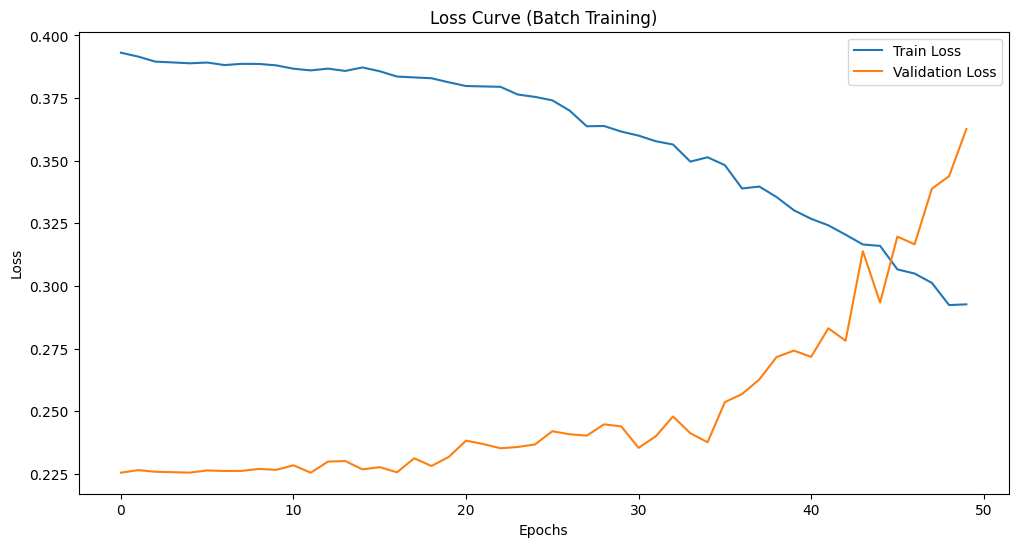

In [6]:
# %% [markdown]
# ### 5. Training Loop (Mini-Batch)

# %%
train_losses = []
test_losses = []

print("🚀 Starting Batch Training...")

for epoch in tqdm(range(EPOCHS)):
    model.train()
    batch_losses = []
    
    # Mini-Batch Loop
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        
        outputs = model(X_batch)
        loss = criterion(outputs.squeeze(), y_batch)
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) # Prevent explosion
        optimizer.step()
        
        batch_losses.append(loss.item())
    
    # Record average train loss for the epoch
    train_losses.append(np.mean(batch_losses))
    
    # Validation
    model.eval()
    val_batch_losses = []
    with torch.no_grad():
        for X_val, y_val in test_loader:
            test_out = model(X_val)
            test_loss = criterion(test_out.squeeze(), y_val)
            val_batch_losses.append(test_loss.item())
            
    test_losses.append(np.mean(val_batch_losses))
    
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}: Train Loss {train_losses[-1]:.6f}, Val Loss {test_losses[-1]:.6f}")

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Validation Loss")
plt.title("Loss Curve (Batch Training)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [7]:
 %% [markdown]
# ### 6. Save Model

# %%
os.makedirs('../models', exist_ok=True)
torch.save(model.state_dict(), '../models/lstm_v1.pth')
print("💾 Model saved to models/lstm_v1.pth")


IndentationError: unexpected indent (2211238750.py, line 1)

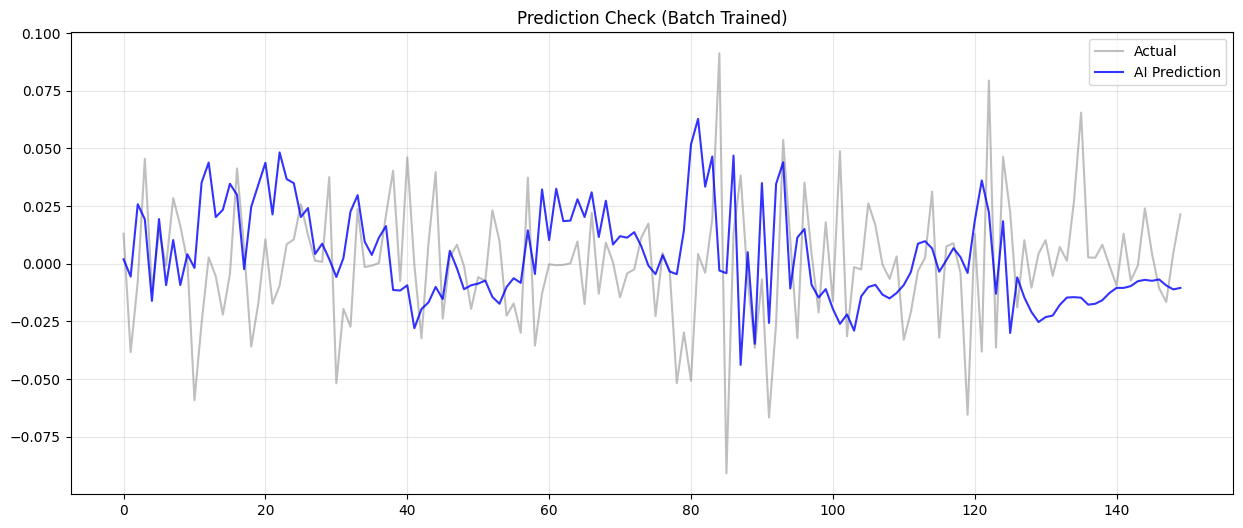

Predicted Std Dev: 0.01895
✅ AI is active and taking risks!


In [12]:
# %% [markdown]
# ### 7. Verify Predictions (Detailed Check)

# %%
model.eval()
preds = []
actuals = []

with torch.no_grad():
    for X_val, y_val in test_loader:
        output = model(X_val).squeeze()
        preds.extend(output.numpy())
        actuals.extend(y_val.numpy())

# Scale back to reality
# We need dummy arrays for inverse transform
dummy_preds = np.zeros((len(preds), 7))
dummy_actuals = np.zeros((len(actuals), 7))

dummy_preds[:, 0] = preds
dummy_actuals[:, 0] = actuals

preds_real = scaler.inverse_transform(dummy_preds)[:, 0]
actuals_real = scaler.inverse_transform(dummy_actuals)[:, 0]

# Plot
plt.figure(figsize=(15, 6))
plt.plot(actuals_real[:150], label="Actual", color='gray', alpha=0.5)
plt.plot(preds_real[:150], label="AI Prediction", color='blue', alpha=0.8)
plt.title("Prediction Check (Batch Trained)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Variance Check
pred_std = np.std(preds_real)
print(f"Predicted Std Dev: {pred_std:.5f}")
if pred_std < 0.001:
    print("⚠️ Still flatlining. Try increasing HIDDEN_DIM or changing features.")
else:
    print("✅ AI is active and taking risks!")